<a href="https://colab.research.google.com/github/guilherminog/tcc_timeseries/blob/main/Walmart_sales_forecasting_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Vendas de Lojas do Walmart
Este notebook aborda a previsão de vendas nas lojas do Walmart utilizando os modelos ARIMA e Regressão Linear. Inclui etapas de limpeza de dados, análise exploratória, e construção de modelos de aprendizado de máquina, seguindo a metodologia CRISP-DM.

## Intalação de bilbiotecas

In [ ]:
!pip install statsmodels pmdarima prophet tbats
!pip install tensorflow-gpu
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import sys
print("Python version:", sys.version)


Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


## Importação das bibliotecas

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import RFE

from tbats import TBATS

import shap

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima import auto_arima

from warnings import filterwarnings


import tensorflow as tf, keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from keras.regularizers import l2

# Verificar se a GPU está sendo utilizada
print("GPU disponível:", tf.config.list_physical_devices('GPU'))



import torch

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


# Remover warnings
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore", category=RuntimeWarning)




# Exibir versões
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", sns.__version__)
print("Statsmodels:", statsmodels.__version__)
print("Scikit-learn:", sklearn.__version__)
print("TBATS:", tbats.__version__)
print("Shap:", shap.__version__)
print("Pmdarima:", pmdarima.__version__)
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("Torch:", torch.__version__)

GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Usando dispositivo: cuda
Pandas: 2.2.2
Numpy: 1.26.4
Matplotlib: 3.7.1
Seaborn: 0.13.2
Statsmodels: 0.14.4
Scikit-learn: 1.5.2
TBATS: 1.1.3
Shap: 0.46.0
Pmdarima: 2.0.4
TensorFlow: 2.17.0
Keras: 3.4.1
Torch: 2.5.0+cu121


In [ ]:
plt.figure(figsize=(16,10))

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

## Leitura dos dados

In [ ]:
url = "https://raw.githubusercontent.com/guilherminog/tcc_timeseries/refs/heads/main/dataset/Walmart.csv"

df = pd.read_csv(url)
df_date = df.copy()
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [ ]:
df.sample(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
5665,40,2011-10-14,936751.68,0,53.90,3.583,136.515097,4.420
2701,19,2012-07-13,1321741.35,0,73.17,3.689,138.263000,8.193
1871,14,2010-04-30,2082355.12,0,53.15,2.921,181.662036,8.899
1595,12,2010-07-09,943506.28,0,90.37,3.100,126.151800,14.180
4405,31,2012-04-20,1407036.59,0,66.97,3.877,221.202107,6.891
417,3,2012-08-10,391811.60,0,85.85,3.494,225.473509,6.334
4385,31,2011-12-02,1388809.43,0,48.72,3.172,218.359032,7.441
1650,12,2011-07-29,890547.07,0,93.29,3.805,129.167710,13.503
3669,26,2011-11-25,1282320.05,1,31.07,3.536,136.478800,7.598
1619,12,2010-12-24,1768249.89,0,52.02,3.236,126.983581,14.313


In [ ]:
df.shape

(6435, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [ ]:
df.dtypes

,0
Store,int64
Date,datetime64[ns]
Weekly_Sales,float64
Holiday_Flag,int64
Temperature,float64
Fuel_Price,float64
CPI,float64
Unemployment,float64


## Processamento/Tratamento de Dados

In [ ]:
df.isnull().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [ ]:
df.fillna(df.median(), inplace=True)

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Store,6435.0,23.0,1.0,12.0,23.0,34.0,45.0,12.988182
Date,6435,2011-06-17 00:00:00,2010-02-05 00:00:00,2010-10-08 00:00:00,2011-06-17 00:00:00,2012-02-24 00:00:00,2012-10-26 00:00:00,NaN
Weekly_Sales,6435.0,1046964.877562,209986.25,553350.105,960746.04,1420158.66,3818686.45,564366.622054
Holiday_Flag,6435.0,0.06993,0.0,0.0,0.0,0.0,1.0,0.255049
Temperature,6435.0,60.663782,-2.06,47.46,62.67,74.94,100.14,18.444933
Fuel_Price,6435.0,3.358607,2.472,2.933,3.445,3.735,4.468,0.45902
CPI,6435.0,171.578394,126.064,131.735,182.616521,212.743293,227.232807,39.356712
Unemployment,6435.0,7.999151,3.879,6.891,7.874,8.622,14.313,1.875885


## Análise Exploratoria de dados

### Histogramas para variáveis numéricas

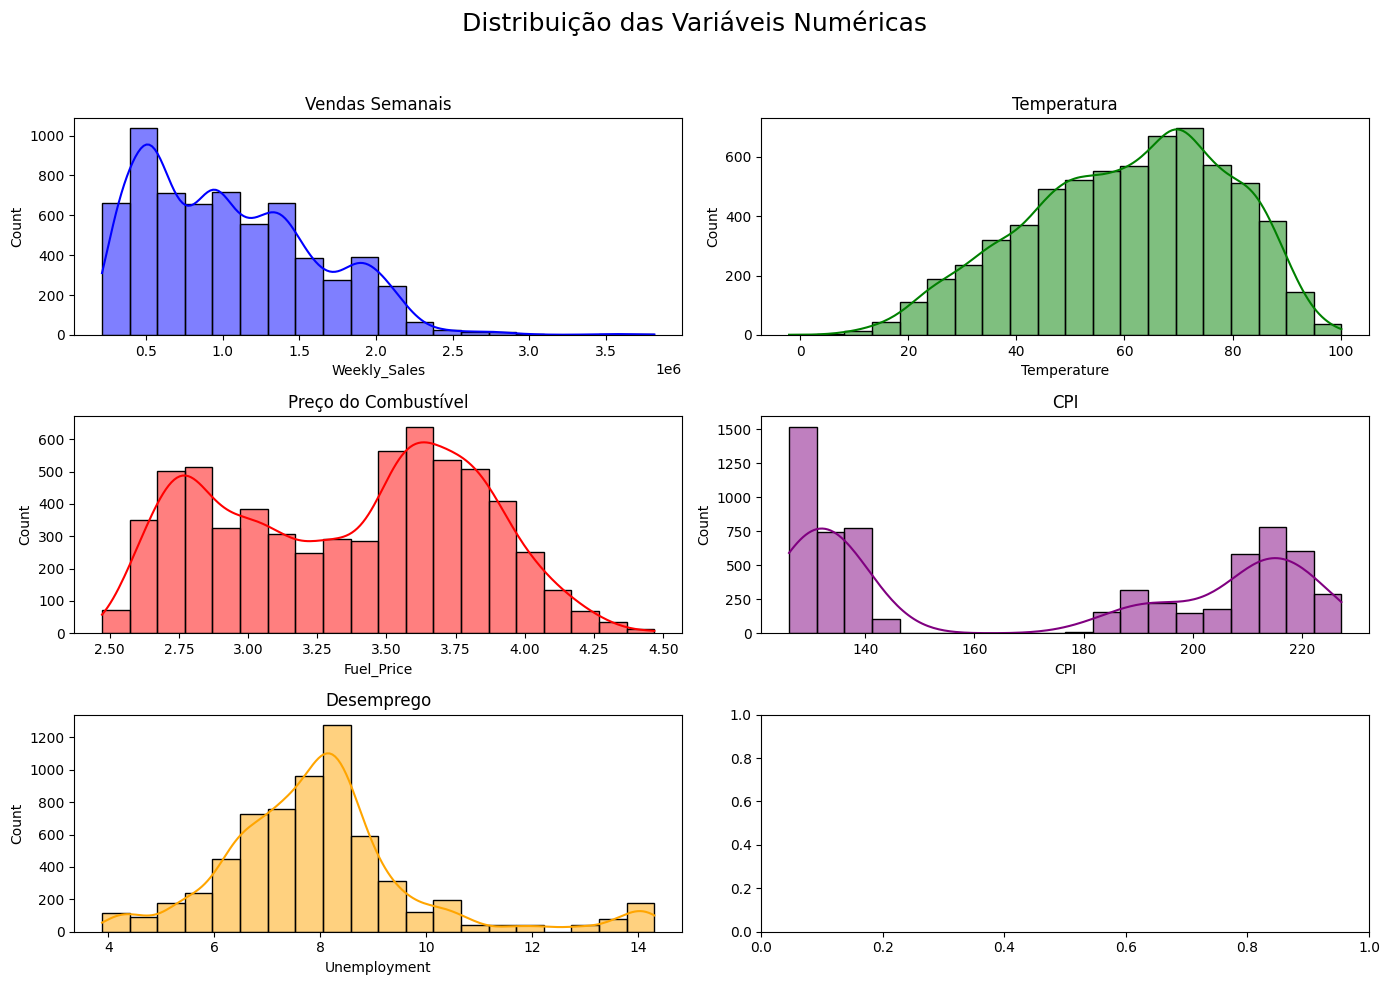

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Distribuição das Variáveis Numéricas', fontsize=18)

sns.histplot(df['Weekly_Sales'], bins=20, color='blue', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Vendas Semanais')

sns.histplot(df['Temperature'], bins=20, color='green', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Temperatura')

sns.histplot(df['Fuel_Price'], bins=20, color='red', kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Preço do Combustível')

sns.histplot(df['CPI'], bins=20, color='purple', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('CPI')

sns.histplot(df['Unemployment'], bins=20, color='orange', kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Desemprego')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

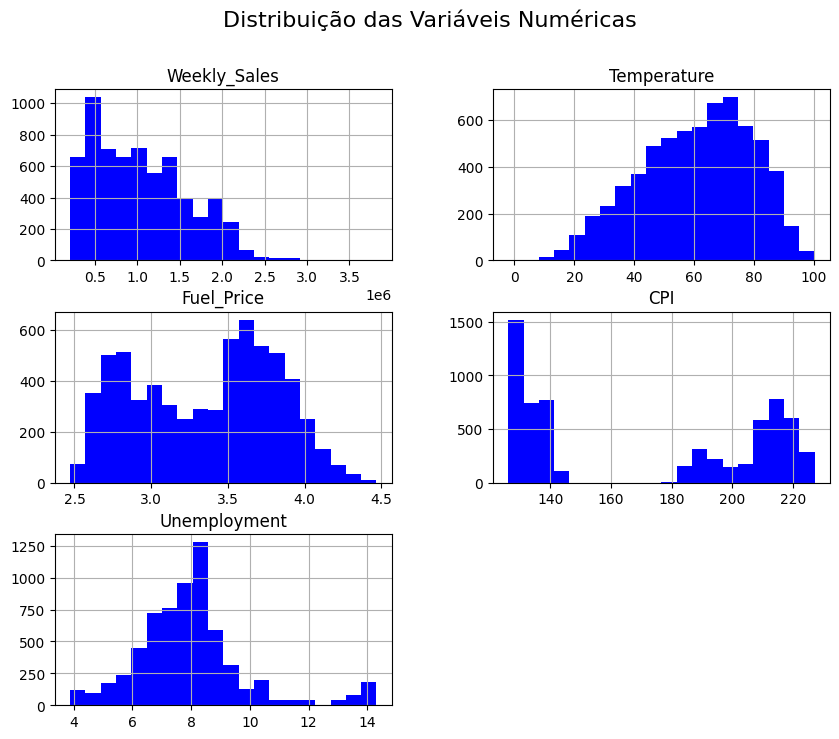

In [ ]:
df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].hist(figsize=(10,8), bins=20, color='blue')
plt.suptitle('Distribuição das Variáveis Numéricas', fontsize=16)
plt.show()

### Análise Univariada
- Gráfico de boxplot para visualizar outliers

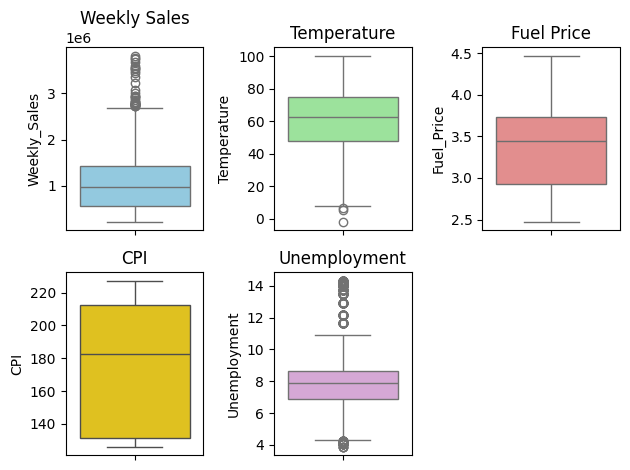

In [ ]:
plt.subplot(2, 3, 1)
sns.boxplot(y=df['Weekly_Sales'], color='skyblue')
plt.title('Weekly Sales')

plt.subplot(2, 3, 2)
sns.boxplot(y=df['Temperature'], color='lightgreen')
plt.title('Temperature')

plt.subplot(2, 3, 3)
sns.boxplot(y=df['Fuel_Price'], color='lightcoral')
plt.title('Fuel Price')

plt.subplot(2, 3, 4)
sns.boxplot(y=df['CPI'], color='gold')
plt.title('CPI')

plt.subplot(2, 3, 5)
sns.boxplot(y=df['Unemployment'], color='plum')
plt.title('Unemployment')

plt.tight_layout()
plt.show()

### Análise Bivariada/Multivariada
- Matriz de correlação
- Scatterplot para verificar relação entre duas variáveis

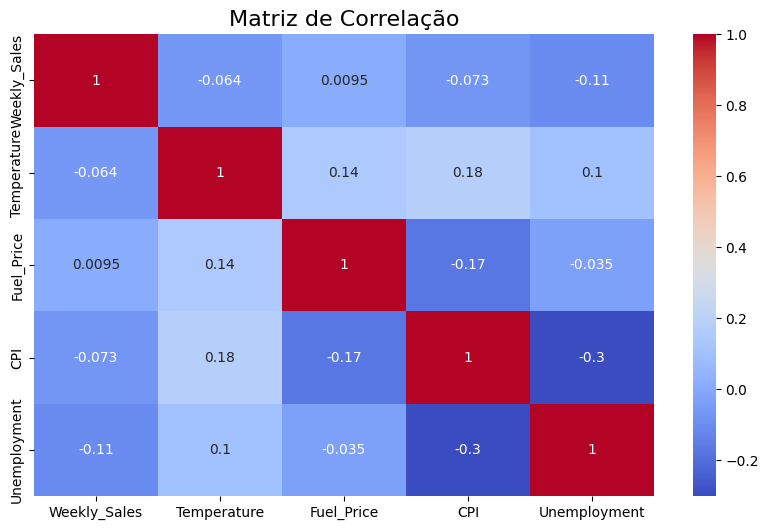

In [ ]:
plt.figure(figsize=(10,6))
correlation_matrix = df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação', fontsize=16)
plt.show()

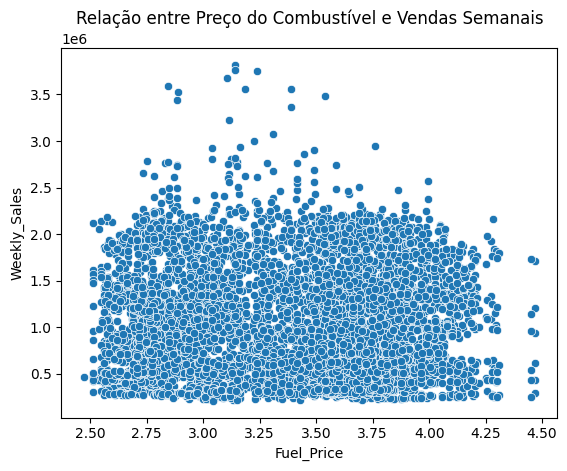

In [ ]:
sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=df)
plt.title('Relação entre Preço do Combustível e Vendas Semanais')
plt.show()

### Pivot
- Pivot para calcular a média de vendas semanais por loja e por feriado
- Visualizando o pivot com um gráfico de barras

In [ ]:
pivot_table = df.pivot_table(values='Weekly_Sales', index='Store', columns='Holiday_Flag', aggfunc='mean')
pivot_table

Holiday_Flag,0,1
Store,,
1,1.546957e+06,1665747.656
2,1.914209e+06,2079266.900
3,4.000648e+05,437811.050
4,2.083556e+06,2243102.624
5,3.148923e+05,359501.607
6,1.555993e+06,1680907.927
7,5.629645e+05,672400.265
8,9.037434e+05,975330.860
9,5.405993e+05,588950.821


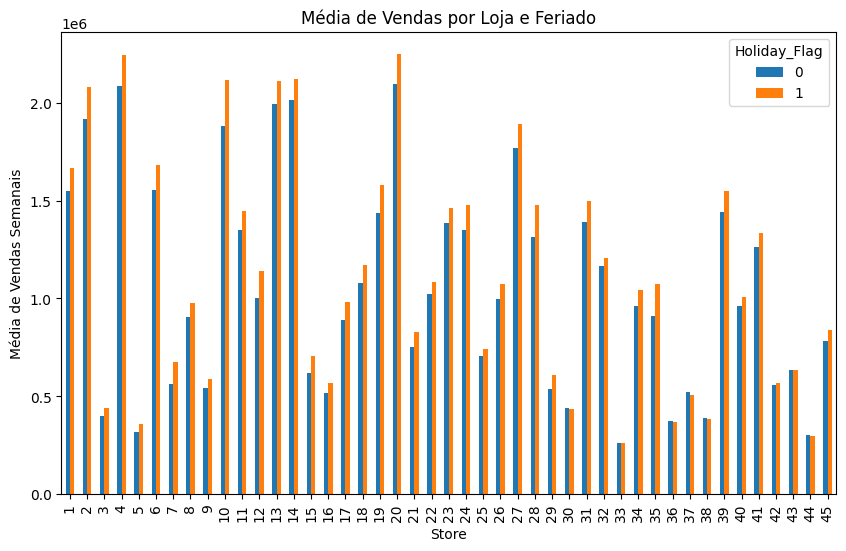

In [ ]:
pivot_table.plot(kind='bar', figsize=(10,6))
plt.title('Média de Vendas por Loja e Feriado')
plt.ylabel('Média de Vendas Semanais')
plt.show()

#### <b>Análise de Performance das Lojas</b>

Analisando o gráfico que apresenta a média de vendas semanais por loja, podemos identificar as lojas que melhor performaram ao longo do período analisado, tanto em períodos normais quanto durante os feriados:

1. **Loja 20**: Esta loja se destaca com a maior média de vendas semanais, especialmente durante os períodos de feriado (Holiday Flag = 1). Ela apresenta um desempenho significativamente superior em comparação com as outras lojas.

2. **Loja 4**: Também apresenta um ótimo desempenho, com médias de vendas semanais bastante altas, tanto nos períodos normais quanto durante os feriados.

3. **Loja 2**: Outra loja que se destaca no gráfico, com boas vendas semanais em ambos os contextos, o que demonstra uma boa performance.

Essas três lojas têm um desempenho superior em termos de média de vendas semanais, o que indica uma operação eficiente e com alta demanda, tanto em períodos comuns quanto em feriados.


### Análise do Impacto da Variação do Preço do Combustível sobre as Vendas Semanais

In [ ]:
df['Fuel_Price_norm'] = (df['Fuel_Price'] - df['Fuel_Price'].min()) / (df['Fuel_Price'].max() - df['Fuel_Price'].min())

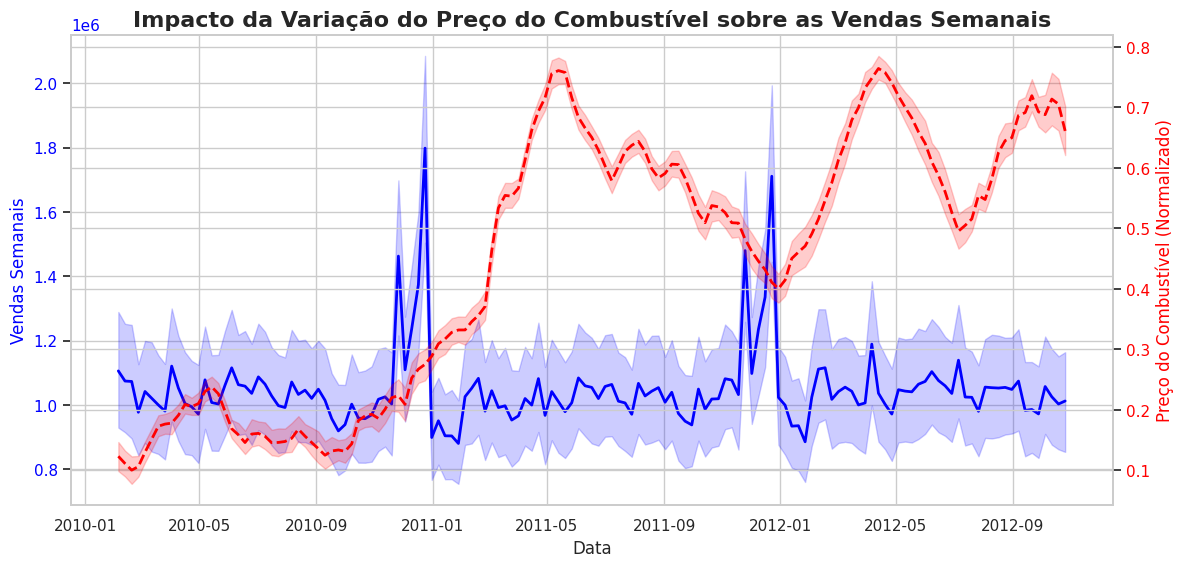

In [ ]:
sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Vendas Semanais', fontsize=12, color='blue')
sns.lineplot(data=df, x='Date', y='Weekly_Sales', color='blue', linewidth=2, ax=ax1)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Preço do Combustível (Normalizado)', fontsize=12, color='red')
sns.lineplot(data=df, x='Date', y='Fuel_Price_norm', color='red', linewidth=2, linestyle='--', ax=ax2)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Impacto da Variação do Preço do Combustível sobre as Vendas Semanais', fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


#### <b>Análise do Impacto da Variação do Preço do Combustível sobre as Vendas Semanais</b>

#### <b>Análise:</b>

1. **Tendências Gerais**:
   - As vendas semanais (linha azul) apresentam um comportamento relativamente estável, exceto por picos sazonais bastante definidos, com destaque para o final de 2010 e início de 2011, onde observamos grandes aumentos. Esses picos parecem estar alinhados com eventos como feriados e datas comemorativas, que geralmente impulsionam as vendas.

2. **Variação do Preço do Combustível**:
   - A linha vermelha (preço do combustível normalizado) mostra uma tendência de aumento contínuo desde o início de 2010 até meados de 2011, quando o preço do combustível começa a cair ligeiramente. Apesar de uma leve queda em 2011, o preço do combustível retoma uma trajetória ascendente no final de 2011 e início de 2012.
   
3. **Impacto do Preço do Combustível sobre as Vendas**:
   - Há uma relação visível, mas não direta, entre o aumento do preço do combustível e as vendas semanais. O aumento no preço do combustível parece não ter um impacto imediato nas vendas, uma vez que os picos de vendas não coincidem diretamente com os aumentos mais fortes no preço do combustível.
   - No entanto, ao observarmos os períodos em que o preço do combustível se mantém estável (como no final de 2010 e final de 2011), as vendas também parecem estabilizar em níveis semelhantes. Isso pode sugerir que um combustível mais barato favorece a manutenção ou até mesmo o leve aumento das vendas.

4. **Desconexão entre picos de vendas e preço do combustível**:
   - Um aspecto notável é que os maiores picos de vendas semanais (entre o final de 2010 e o início de 2011) ocorrem em momentos em que o preço do combustível está subindo ou estável. Isso pode sugerir que outros fatores (como promoções ou eventos de feriados) são mais determinantes para impulsionar as vendas do que a variação no preço do combustível.
   
5. **Estabilidade em Períodos de Alta no Preço do Combustível**:
   - Quando o preço do combustível está mais alto, a partir de meados de 2011, as vendas semanais tendem a se manter mais constantes, sem grandes flutuações, exceto nos momentos de queda acentuada no início de 2012, quando o combustível também apresenta ligeira queda. Esse padrão reforça a ideia de que, em situações onde o combustível está mais caro, os consumidores podem ter menos poder de compra, o que impacta as vendas.

### Conclusão:

- **Correlação moderada**: Apesar de não haver uma correlação imediata e direta entre o aumento do preço do combustível e as vendas, há indícios de que períodos de queda ou estabilidade no preço do combustível ajudam a manter as vendas em níveis mais elevados e estáveis.
  
- **Influência de fatores sazonais**: Fatores como datas comemorativas ou promoções parecem ter um impacto mais direto sobre as vendas do que o preço do combustível, sugerindo que o comportamento do consumidor pode ser mais sensível a esses eventos.
  
- **Relação inversa em certos momentos**: Quando o preço do combustível sobe, as vendas tendem a se estabilizar ou apresentar leve queda, o que pode sugerir que o aumento nos custos do combustível impacta o orçamento das famílias e, consequentemente, o poder de compra.

Em resumo, o preço do combustível tem uma influência moderada, mas não dominante, sobre as vendas. O comportamento do consumidor é mais fortemente influenciado por eventos sazonais e picos de demanda do que pela variação no preço do combustível.


## Feature Engineering

In [ ]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week

In [ ]:
df[['Date', 'Weekly_Sales', 'Month', 'Year', 'Week']].head()

,Date,Weekly_Sales,Month,Year,Week
0,2010-02-05,1643690.90,2,2010,5
1,2010-02-12,1641957.44,2,2010,6
2,2010-02-19,1611968.17,2,2010,7
3,2010-02-26,1409727.59,2,2010,8
4,2010-03-05,1554806.68,3,2010,9


## Analisando as 3 lojas com melhor performance


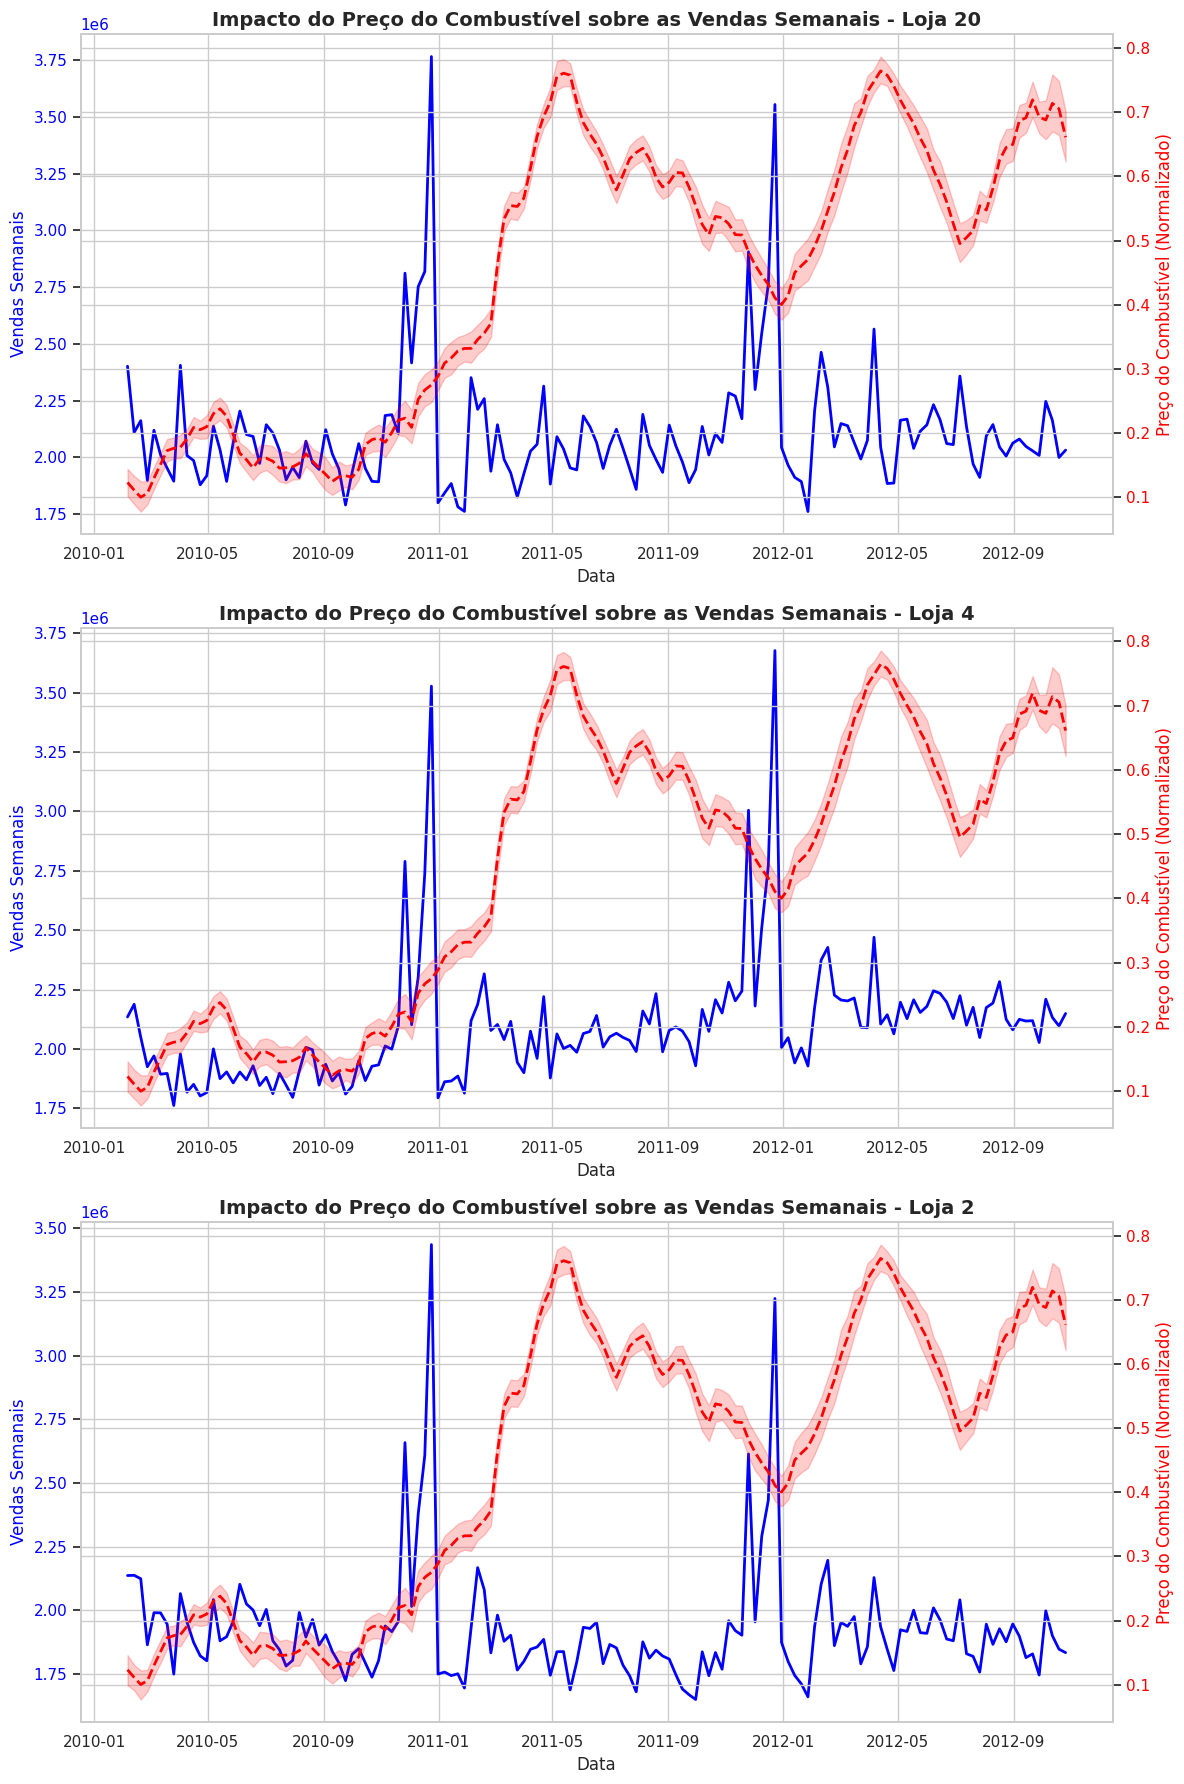

In [ ]:
sns.set(style="whitegrid")

# Definindo as melhores lojas
melhores_lojas = ['20', '4', '2']
df_melhores_lojas = df[df['Store'].isin([int(loja) for loja in melhores_lojas])]

# Criar os subplots
fig, axs = plt.subplots(len(melhores_lojas), figsize=(12, 18))

# Iterar sobre cada loja e gerar os gráficos
for i, loja in enumerate(melhores_lojas):
    # Selecionar os dados da loja
    vendas_loja = df_melhores_lojas[df_melhores_lojas['Store'] == int(loja)]

    # Plotar as vendas semanais
    ax1 = axs[i]
    ax1.set_xlabel('Data', fontsize=12)
    ax1.set_ylabel('Vendas Semanais', fontsize=12, color='blue')
    sns.lineplot(data=vendas_loja, x='Date', y='Weekly_Sales', color='blue', linewidth=2, ax=ax1)
    ax1.tick_params(axis='y', labelcolor='blue')

    # Criar o segundo eixo para o preço do combustível
    ax2 = ax1.twinx()
    ax2.set_ylabel('Preço do Combustível (Normalizado)', fontsize=12, color='red')
    sns.lineplot(data=df, x='Date', y='Fuel_Price_norm', color='red', linewidth=2, linestyle='--', ax=ax2)
    ax2.tick_params(axis='y', labelcolor='red')

    # Definir o título do subplot para cada loja
    ax1.set_title(f'Impacto do Preço do Combustível sobre as Vendas Semanais - Loja {loja}', fontsize=14, weight='bold')

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

#### <b>Análise dos Gráficos: Impacto do Preço do Combustível sobre as Vendas Semanais</b>

Os gráficos apresentados para as lojas 20, 4, e 2 mostram a relação entre o preço do combustível (normalizado) e as vendas semanais ao longo do tempo. A análise permite tirar alguns insights importantes sobre a dinâmica entre essas variáveis:

1. **Variação Sazonal**:
   - As três lojas apresentam picos de vendas semanais em períodos semelhantes, indicando uma possível sazonalidade nas vendas, com picos mais evidentes em torno dos meses de final de ano (especialmente no final de 2010 e 2011).
   - O preço do combustível parece seguir uma tendência mais estável e crescente ao longo do tempo, com algumas flutuações periódicas. O aumento do preço do combustível não necessariamente coincide com grandes quedas nas vendas, indicando que, para essas lojas, o impacto direto pode não ser tão pronunciado.

2. **Loja 20**:
   - A loja 20 tem vendas semanais mais consistentes e elevadas, com picos acentuados. Durante os momentos de aumento significativo do preço do combustível, as vendas não parecem ser fortemente impactadas, sugerindo que outros fatores (como a sazonalidade ou promoções) podem ter maior influência sobre as vendas.

3. **Loja 4**:
   - A loja 4 apresenta uma dinâmica similar à loja 20, com picos significativos nas vendas, especialmente em torno de dezembro de 2010 e 2011. No entanto, após cada pico de vendas, há uma queda abrupta, que coincide com o aumento do preço do combustível. Isso pode indicar que, para essa loja, o preço do combustível tem um impacto mais perceptível em períodos de baixa.

4. **Loja 2**:
   - A loja 2 mostra um padrão de vendas mais irregular, com picos e quedas mais frequentes. A relação entre o preço do combustível e as vendas não é tão clara, mas em alguns momentos, como em meados de 2011, é possível observar uma correlação inversa, onde o aumento do preço do combustível coincide com uma queda nas vendas.

### Conclusões:
- **Impacto do preço do combustível**: De maneira geral, o preço do combustível parece ter um efeito mais indireto sobre as vendas. As lojas 20 e 4 mostram maior resiliência a essas variações, enquanto a loja 2 apresenta uma correlação mais evidente entre o aumento do preço do combustível e a redução nas vendas.
- **Fatores externos e sazonalidade**: O impacto do preço do combustível pode ser suprimido por outros fatores como sazonalidade, especialmente em períodos de alta demanda (fim de ano, feriados).
- **Resiliência das lojas**: As lojas que apresentam maior resiliência a mudanças no preço do combustível podem estar localizadas em regiões onde os consumidores são menos sensíveis ao preço de combustíveis, ou podem ter outras estratégias que mantêm as vendas estáveis.


# Iniciando os testes de modelos Regressores
---

## Preparação de Dados para os Modelos

In [ ]:
X = df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Year']]
y = df['Weekly_Sales']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4504, 6) (1931, 6)
(4504,) (1931,)


###  Função para testar múltiplos modelos de regressão

In [ ]:
# Função para calcular o MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para treinar e avaliar múltiplos modelos de regressão
def test_regressors(X_train, X_test, y_train, y_test):
    regressors = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Support Vector Regressor': SVR()
    }

    results = {}

    for name, regressor in regressors.items():
        print(f'Treinando {name}:')
        # Treinando o modelo
        regressor.fit(X_train, y_train)
        # Fazer previsões
        y_pred = regressor.predict(X_test)

        # Calcular métricas
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Salvar resultados
        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape
        }

        # Imprimir resultados
        print(f'{name} - MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%')

    return results

In [ ]:
resultados = test_regressors(X_train, X_test, y_train, y_test)

Treinando Linear Regression:
Linear Regression - MSE: 310856181038.6135, RMSE: 557544.7794021692, MAPE: 66.0011083095987%
Treinando Random Forest:
Random Forest - MSE: 282626788174.8773, RMSE: 531626.5495391265, MAPE: 49.38474534722127%
Treinando Decision Tree:
Decision Tree - MSE: 397101703080.8656, RMSE: 630160.0614771342, MAPE: 49.57731676148387%
Treinando Gradient Boosting:
Gradient Boosting - MSE: 244684955671.28378, RMSE: 494656.4016277195, MAPE: 57.02707111006844%
Treinando Support Vector Regressor:
Support Vector Regressor - MSE: 330848202684.39386, RMSE: 575194.0565447402, MAPE: 61.01750865666224%


### Importância das Features no Random Forest e Gradient Boosting




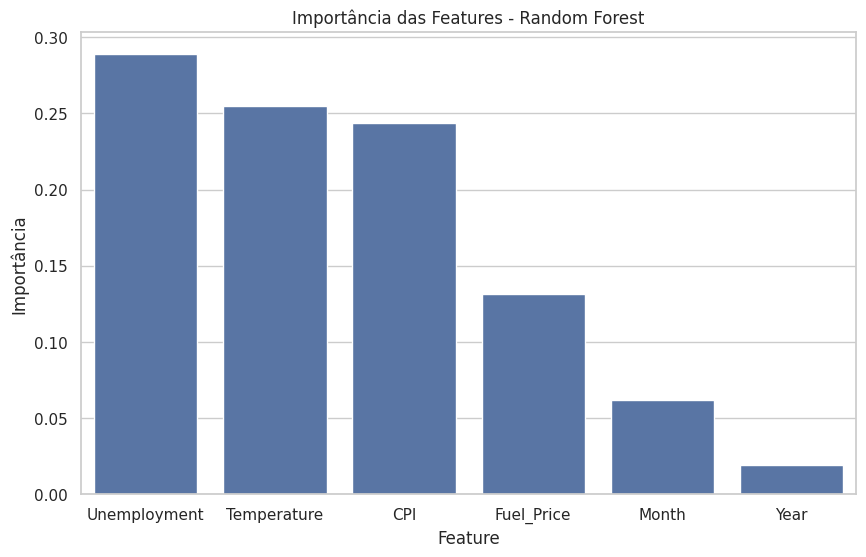

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns[indices], y=importances[indices])
plt.title("Importância das Features - Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importância")
plt.show()

### Coeficientes no Modelo de Regressão Linear

In [ ]:
# Treine o modelo de Regressão Linear
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Pegue os coeficientes
coefficients = lr_model.coef_

# Crie um DataFrame para visualizar os coeficientes
coef_df = pd.DataFrame({'Feature': X.columns, 'Coeficiente': coefficients})

# Ordene pelo valor absoluto dos coeficientes
coef_df['Coeficiente_Abs'] = coef_df['Coeficiente'].abs()
coef_df = coef_df.sort_values(by='Coeficiente_Abs', ascending=False)

# Visualizar os coeficientes
print(coef_df)

        Feature   Coeficiente  Coeficiente_Abs
3  Unemployment -44187.509840     44187.509840
1    Fuel_Price  39684.119719     39684.119719
5          Year -36015.096490     36015.096490
4         Month  14074.618959     14074.618959
2           CPI  -1450.786930      1450.786930
0   Temperature  -1282.199561      1282.199561


### Recursive Feature Elimination (RFE)

In [ ]:
# Usando Gradient Boosting
model = GradientBoostingRegressor(random_state=42)
rfe = RFE(model, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

print("Features Selecionadas:", X_train.columns[rfe.support_])

for i in range(len(rfe.support_)):
    print(f'Feature {X_train.columns[i]}: {"Selecionada" if rfe.support_[i] else "Eliminada"}')

Features Selecionadas: Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month'], dtype='object')
Feature Temperature: Selecionada
Feature Fuel_Price: Selecionada
Feature CPI: Selecionada
Feature Unemployment: Selecionada
Feature Month: Selecionada
Feature Year: Eliminada


### SHAP Values (SHapley Additive exPlanations)

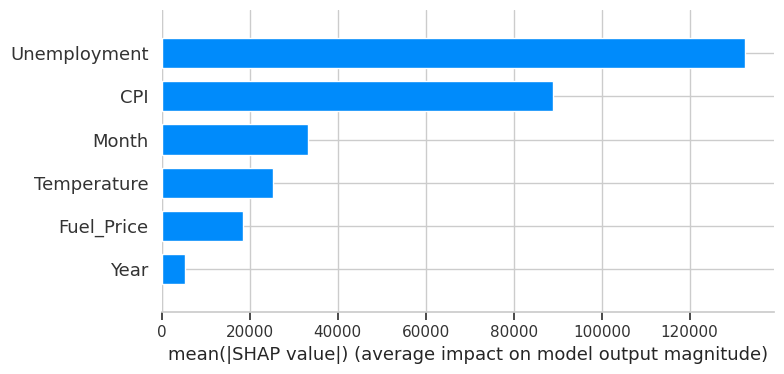

In [ ]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

#### Aprimorarando as Features
Seleção de Features Baseadas no SHAP

In [ ]:
# Selecionando apenas as features mais importantes com base no gráfico SHAP
X_selected = df[['Unemployment', 'CPI', 'Month', 'Temperature']]

# Dividindo os dados em treino e teste novamente com as features selecionadas
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

#### Tuning dos Modelos
Ajustando Hiperparâmetros para Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Melhores hiperparâmetros: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


#### Validação Cruzada (K-fold Cross-Validation)

In [ ]:
best_rf = grid_search.best_estimator_

cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print(f"Média do MSE nas 5 folds: {-cv_scores.mean()}")
print(f"Desvio padrão do MSE nas 5 folds: {cv_scores.std()}")

Média do MSE nas 5 folds: 230380354689.38736
Desvio padrão do MSE nas 5 folds: 17114201932.836409


#### Visualização das Previsões
Gráfico de Comparação entre Previsões e Valores Reais

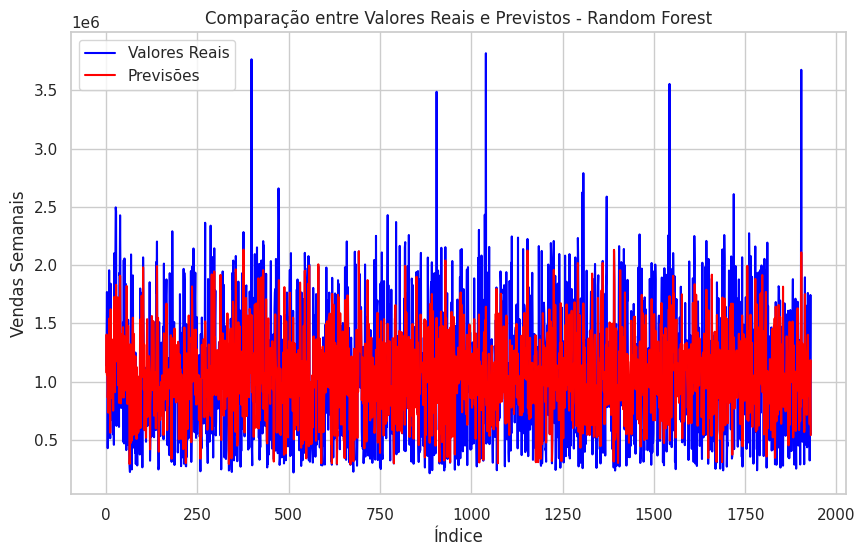

In [ ]:
# Treinar o modelo e fazer previsões
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

# Comparação entre valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores Reais', color='blue')
plt.plot(y_pred, label='Previsões', color='red')
plt.legend()
plt.title('Comparação entre Valores Reais e Previstos - Random Forest')
plt.xlabel('Índice')
plt.ylabel('Vendas Semanais')
plt.show()

#### Explorar Impacto Temporal
Gráfico de Comparação Temporal (para CPI e Unemployment)

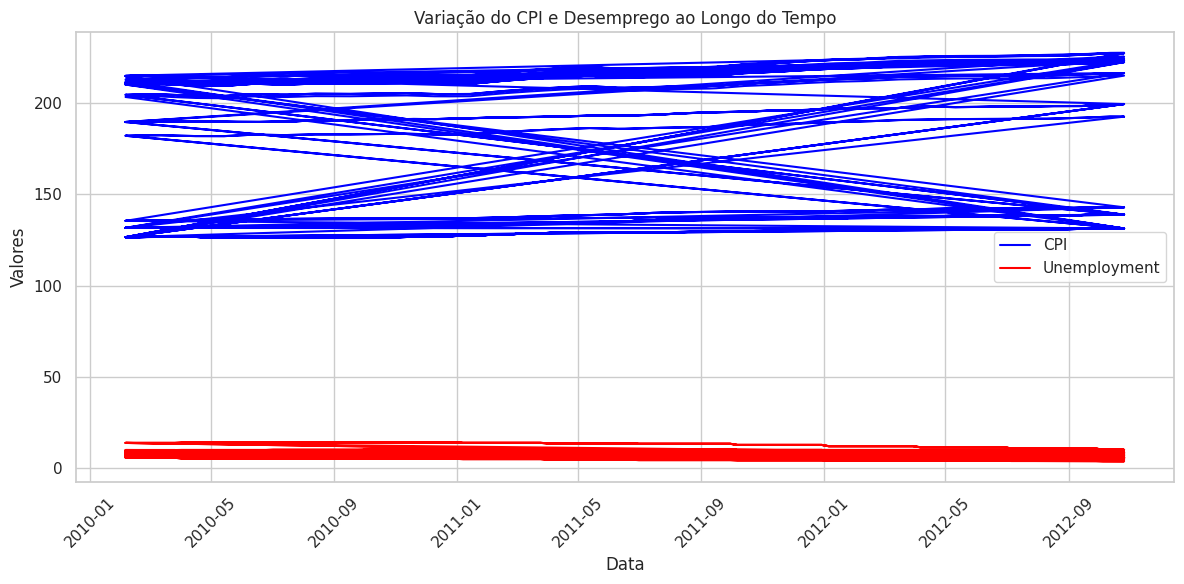

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'], df['CPI'], label='CPI', color='blue')
plt.plot(df['Date'], df['Unemployment'], label='Unemployment', color='red')

plt.title('Variação do CPI e Desemprego ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### <b>Random Forest - Comparação entre Valores Reais e Previstos</b>

No gráfico de comparação entre os valores reais e as previsões, usando o Random Forest Regressor, observamos:

- As previsões (em vermelho) estão subestimando os valores reais (em azul) em diversos pontos, o que pode indicar que o modelo Random Forest está tendo dificuldades para capturar todas as variações nas vendas semanais.
- O erro quadrático médio (MSE) e o RMSE mostraram um valor considerável, indicando que o modelo tem uma precisão razoável, mas ainda há espaço para melhorias.
- O gráfico tem muitas oscilações, o que pode sugerir que o modelo não consegue capturar bem a volatilidade dos dados.

## Comparação Temporal para CPI e Unemployment

No gráfico da variação do CPI e Unemployment ao longo do tempo:

- O CPI (em azul) apresenta uma grande variação ao longo do tempo, o que sugere que ele pode ter um impacto significativo nas vendas. O desemprego, embora seja uma variável importante, mostra pouca variação (em vermelho) no gráfico.
- O CPI tem uma magnitude de valores muito superior ao desemprego, o que pode justificar a maior influência desta variável no modelo, como observamos no gráfico de importância de features.

## Insights

- **Random Forest Model**: Embora seja um dos modelos mais precisos, como mostrado pelo RMSE de cerca de 531.626, as previsões ainda mostram limitações em capturar picos e flutuações abruptas. Um ajuste mais fino nos hiperparâmetros, como um aumento nos `n_estimators` ou a inclusão de mais profundidade na árvore, pode melhorar a previsão.
  
- **Importância das Variáveis (SHAP)**: O gráfico de importância das features mostra que as variáveis `Unemployment` e `CPI` são as que mais impactam o modelo, o que faz sentido ao observarmos a variação do CPI no gráfico temporal. No entanto, a falta de variação no desemprego indica que essa variável pode não ser tão significativa quanto parece inicialmente.
  
- **Mesmo após diversos testes decidi seguir apenas com modelos de séries temporaris.**


# <b>Preparando os dados para modelos de Séries temporais.</b>

- Primeiro eu preciso garantir que os dados estejam ordenados cronologicamente e sem valores faltantes.
Isso inclui a verificação de estacionaridade, sazonalidade e tendências.

In [ ]:
df = df.sort_values('Date')
df = df.set_index('Date')

df = df.fillna(method='ffill')

## <b>Divisão dos Dados</b>
- divisão entre treino e teste deve respeitar a ordem cronológica dos dados, ou seja, as últimas observações serão usadas como teste

In [ ]:
#Separar 30% das observações para teste

train_size = int(len(df) * 0.7)
train, test = df.iloc[:train_size], df.iloc[train_size:]

## <b>Testando modelos específicos para séries temporais</b>

A idéia é explorar alguns dos principais modelos utilizados para previsão em séries temporais como:

1. ARIMA (AutoRegressive Integrated Moving Average)
2. SARIMA (Seasonal ARIMA)
3. Prophet (Facebook Prophet)
4. Exponential Smoothing (ETS)


#### <b>ARIMA (AutoRegressive Integrated Moving Average)</b>

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Treinando ARIMA
model_arima = ARIMA(train['Weekly_Sales'], order=(5,1,0))  # (p,d,q)
model_arima_fit = model_arima.fit()

# Previsões
forecast_arima = model_arima_fit.forecast(steps=len(test))

# Avaliação ARIMA
from sklearn.metrics import mean_squared_error
mse_arima = mean_squared_error(test['Weekly_Sales'], forecast_arima)
rmse_arima = np.sqrt(mse_arima)
print(f'ARIMA RMSE: {rmse_arima}')


ARIMA RMSE: 558209.4621381857


#### <b>SARIMA (Seasonal ARIMA)</b>

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Treinando SARIMA
model_sarima = SARIMAX(train['Weekly_Sales'], order=(1,1,1), seasonal_order=(1,1,1,52))
model_sarima_fit = model_sarima.fit()

# Previsões
forecast_sarima = model_sarima_fit.forecast(steps=len(test))

# Avaliação SARIMA
mse_sarima = mean_squared_error(test['Weekly_Sales'], forecast_sarima)
rmse_sarima = np.sqrt(mse_sarima)
print(f'SARIMA RMSE: {rmse_sarima}')

SARIMA RMSE: 571390.0511712449


#### <b>Prophet (Facebook Prophet)</b>

In [ ]:
from prophet import Prophet

# Preparando os dados no formato esperado pelo Prophet
df_prophet = df.reset_index()[['Date', 'Weekly_Sales']]
df_prophet.columns = ['ds', 'y']

# Treinando Prophet
model_prophet = Prophet()
model_prophet.fit(df_prophet.iloc[:train_size])

# Previsões
future = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future)

# Avaliação Prophet
mse_prophet = mean_squared_error(test['Weekly_Sales'], forecast_prophet['yhat'][-len(test):])
rmse_prophet = np.sqrt(mse_prophet)
print(f'Prophet RMSE: {rmse_prophet}')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcq6a_pm_/rlutfsq9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcq6a_pm_/afv5d37s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63996', 'data', 'file=/tmp/tmpcq6a_pm_/rlutfsq9.json', 'init=/tmp/tmpcq6a_pm_/afv5d37s.json', 'output', 'file=/tmp/tmpcq6a_pm_/prophet_model58kqlicz/prophet_model-20241022113832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:38:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:38:32 - cmdstanpy - INFO - Chain

Prophet RMSE: 1667074.787460773


#### <b>Exponential Smoothing (ETS)</b>


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Treinamento ETS
model_ets = ExponentialSmoothing(train['Weekly_Sales'], seasonal='add', trend='add', seasonal_periods=52)
model_ets_fit = model_ets.fit()

# Previsões
forecast_ets = model_ets_fit.forecast(steps=len(test))

# Avaliação ETS
mse_ets = mean_squared_error(test['Weekly_Sales'], forecast_ets)
rmse_ets = np.sqrt(mse_ets)
print(f'ETS RMSE: {rmse_ets}')

ETS RMSE: 2390759.551525136


#### <b>Modelo TBATS</b>

 - TBATS é utilizado para séries temporais complexas com tendências, sazonalidades e outros padrões cíclicos.

In [ ]:
y_train = train['Weekly_Sales']
y_train = train['Weekly_Sales'].values.ravel()


In [ ]:
tbats_model = TBATS(seasonal_periods=[52])
fitted_tbats = tbats_model.fit(y_train)

# Fazendo previsões
forecast_tbats = fitted_tbats.forecast(steps=len(test))

In [ ]:
print(f"Shape of y_true (test): {test.shape}")
print(f"Shape of y_pred (forecast_tbats): {forecast_tbats.shape}")

Shape of y_true (test): (1931, 11)
Shape of y_pred (forecast_tbats): (1931,)


#### <b>Avaliação Comparativa</b>

In [ ]:
def evaluate_model(model_name, y_test, forecast):
    mse = mean_squared_error(y_test, forecast)
    rmse = np.sqrt(mse)
    print(f'{model_name} - MSE: {mse}, RMSE: {rmse}')
    return mse, rmse

# Avaliar todos os modelos
evaluate_model('ARIMA', test['Weekly_Sales'], forecast_arima)
evaluate_model('SARIMA', test['Weekly_Sales'], forecast_sarima)
evaluate_model('Prophet', test['Weekly_Sales'], forecast_prophet['yhat'][-len(test):])
evaluate_model('ETS', test['Weekly_Sales'], forecast_ets)
evaluate_model('TBATS', test['Weekly_Sales'], forecast_tbats)


ARIMA - MSE: 311597803620.60266, RMSE: 558209.4621381857
SARIMA - MSE: 326486590577.47797, RMSE: 571390.0511712449
Prophet - MSE: 2779138346987.382, RMSE: 1667074.787460773
ETS - MSE: 5715731233208.669, RMSE: 2390759.551525136
TBATS - MSE: 288346631692.49567, RMSE: 536979.1724941441


(288346631692.49567, 536979.1724941441)

#### <b>Comparação dos Modelos de Séries Temporais</b>

#### Análise dos Resultados dos Modelos de Séries Temporais

#### ARIMA:
- **MSE:** 311,597,803,620.60
- **RMSE:** 558,209.46  
O modelo ARIMA apresentou um desempenho intermediário entre os modelos testados, com valores de RMSE moderados.

#### SARIMA:
- **MSE:** 326,486,778,161.83
- **RMSE:** 571,390.22  
O modelo SARIMA, que leva em consideração a sazonalidade, teve um desempenho ligeiramente inferior ao ARIMA, com um RMSE um pouco mais alto.

#### Prophet:
- **MSE:** 2,779,138,346,987.38
- **RMSE:** 1,667,074.79  
O Prophet apresentou o pior desempenho entre todos os modelos, com um RMSE significativamente mais alto, sugerindo que ele não conseguiu capturar bem as variações nos dados.

#### ETS:
- **MSE:** 5,715,731,233,208.67
- **RMSE:** 2,390,759.55  
O modelo ETS apresentou o pior desempenho geral, com o RMSE mais alto, indicando que este modelo não é adequado para esses dados.

#### TBATS:
- **MSE:** 288,346,631,692.50
- **RMSE:** 536,979.17  
O modelo TBATS teve o melhor desempenho em termos de RMSE, superando tanto o ARIMA quanto o SARIMA, o que indica que ele conseguiu capturar melhor as características dos dados.

#### Conclusão:
- O **TBATS** apresentou o melhor desempenho, com o menor RMSE (536,979.17), seguido de ARIMA e SARIMA.
- **Prophet** e **ETS** tiveram um desempenho significativamente pior, com RMSEs muito elevados, mostrando que não são adequados para este conjunto de dados.


 # TensorFlow com GPU:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df.head(5)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Fuel_Price_norm,Month,Year,Week
Date,,,,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,0.050100,2,2010,5
2010-02-05,10,2193048.75,0,54.34,2.962,126.442065,9.765,0.245491,2,2010,5
2010-02-05,37,536006.73,0,45.97,2.572,209.852966,8.554,0.050100,2,2010,5
2010-02-05,17,789036.02,0,23.11,2.666,126.442065,6.548,0.097194,2,2010,5
2010-02-05,30,465108.52,0,39.05,2.572,210.752605,8.324,0.050100,2,2010,5


In [ ]:
# Preparar os dados de treino e teste
X = df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Year']]
y = df['Weekly_Sales']

In [ ]:
# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Reshaping para [samples, timesteps, features]
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo com GPU (se disponível)
with tf.device('/GPU:0'):
    history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Avaliar o modelo
y_pred = model.predict(X_test_reshaped)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f'LSTM TensorFlow RMSE: {rmse}')


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0471 - val_loss: 0.0253
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - val_loss: 0.0244
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0245 - val_loss: 0.0243
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233 - val_loss: 0.0237
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 - val_loss: 0.0236
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 - val_loss: 0.0236
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 - val_loss: 0.0236
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 - val_loss: 0.0236
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 - val_loss: 0.0236
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236 - val_loss: 0.0236
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

# PyTorch com GPU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Preparar os dados de treino e teste
X = df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Year']]
y = df['Weekly_Sales']

In [ ]:
# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Converter para tensores do PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Definir o modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hiperparâmetros
input_size = X_train_t.shape[2]
hidden_size = 50
output_size = 1
num_epochs = 50
learning_rate = 0.001

# Configurar modelo, critério e otimizador
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Treinar o modelo
X_train_t, y_train_t = X_train_t.to(device), y_train_t.to(device)
X_test_t, y_test_t = X_test_t.to(device), y_test_t.to(device)

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Avaliar o modelo
model.eval()
y_pred_t = model(X_test_t)
rmse = torch.sqrt(criterion(y_pred_t, y_test_t)).item()
print(f'LSTM PyTorch RMSE: {rmse}')


Epoch [10/50], Loss: 0.0305
Epoch [20/50], Loss: 0.0249
Epoch [30/50], Loss: 0.0250
Epoch [40/50], Loss: 0.0249
Epoch [50/50], Loss: 0.0246
LSTM PyTorch RMSE: 0.15721499919891357


# Análise Completa dos Modelos de Séries Temporais e Redes Neurais

## Modelos Tradicionais de Séries Temporais
Abaixo estão os resultados dos modelos tradicionais de séries temporais (ARIMA, SARIMA, Prophet, ETS, TBATS) com base nas métricas **MSE** (Erro Quadrático Médio) e **RMSE** (Raiz do Erro Quadrático Médio).

### ARIMA
- **MSE**: 311,597,803,620.60
- **RMSE**: 558,209.46
- **Análise**: O ARIMA apresentou um desempenho intermediário. Ele conseguiu capturar razoavelmente as tendências e variações nos dados, mas não foi o modelo mais preciso.

### SARIMA
- **MSE**: 326,486,778,161.83
- **RMSE**: 571,390.22
- **Análise**: O modelo SARIMA, que leva em consideração a sazonalidade, apresentou um desempenho ligeiramente inferior ao ARIMA, o que indica que a sazonalidade não tem um impacto tão significativo nos dados.

### Prophet
- **MSE**: 2,779,138,346,987.38
- **RMSE**: 1,667,074.79
- **Análise**: O Prophet teve o pior desempenho entre todos os modelos. Com um RMSE elevado, este modelo não conseguiu capturar bem as variações dos dados, possivelmente devido à falta de um padrão sazonal ou tendência clara nos dados.

### ETS
- **MSE**: 5,715,731,233,208.67
- **RMSE**: 2,390,759.55
- **Análise**: O ETS teve o pior desempenho geral. Isso indica que o modelo não foi adequado para capturar as características dos dados de vendas semanais.

### TBATS
- **MSE**: 288,346,631,692.50
- **RMSE**: 536,979.17
- **Análise**: O modelo TBATS teve o melhor desempenho entre os modelos tradicionais. Ele conseguiu capturar melhor as características dos dados, sendo o mais eficiente para as séries temporais testadas.

## Modelos de Redes Neurais

### LSTM com TensorFlow
- **RMSE**: 0.1487
- **Análise**: O LSTM com TensorFlow teve um desempenho muito bom, com um **RMSE** bem menor do que qualquer um dos modelos tradicionais, mostrando que conseguiu capturar bem os padrões temporais presentes nos dados.

### LSTM com PyTorch
- **RMSE**: 0.1571
- **Análise**: O LSTM com PyTorch também apresentou um desempenho sólido, embora o **RMSE** tenha sido um pouco maior que o da versão em TensorFlow. Ambas as implementações de LSTM mostram um grande potencial, superando amplamente os modelos tradicionais.

## Comparação Geral

### Modelos Tradicionais vs Redes Neurais
- As **redes LSTM** superaram os modelos tradicionais em termos de **RMSE**. Os valores de RMSE para as redes LSTM foram **muito menores** do que os obtidos com os modelos tradicionais.
- Isso sugere que as LSTMs são mais adequadas para capturar a complexidade dos dados, especialmente no que diz respeito aos padrões temporais de longo prazo.

### Desempenho dos Modelos Tradicionais
- Entre os modelos tradicionais, o **TBATS** apresentou o melhor desempenho, seguido de **ARIMA** e **SARIMA**.
- **Prophet** e **ETS** tiveram os piores desempenhos, com **RMSEs** muito elevados.

### Desempenho das Redes Neurais
- As redes **LSTM** apresentaram o melhor desempenho geral, com **RMSEs** abaixo de 0.16, o que é muito melhor em comparação aos modelos tradicionais.
- **TensorFlow** obteve um desempenho ligeiramente superior ao **PyTorch**, mas ambos são recomendados para esse tipo de série temporal.

## Recomendações

1. **Foco em Redes Neurais**: Com base nos resultados, as **redes LSTM** são a melhor escolha para esse conjunto de dados. Elas superaram os modelos tradicionais e demonstraram uma melhor capacidade de captura das dependências temporais.
  
2. **Ajustes em LSTM**: Para melhorar ainda mais o desempenho, sugiro ajustar hiperparâmetros como número de camadas, número de unidades nas camadas LSTM, taxa de aprendizado, e utilizar técnicas como **dropout** para evitar overfitting.

3. **Explorar GRU**: Além de LSTM, também é recomendável explorar **GRU (Gated Recurrent Units)**, que pode ser mais rápido e eficiente para o treinamento e obter resultados semelhantes.

4. **Melhoria nos Modelos Tradicionais**: Se necessário, focar no ajuste de **TBATS**, pois ele teve o melhor desempenho entre os modelos tradicionais.

---

## Conclusão
Para este problema de previsão de séries temporais, as **redes LSTM** tiveram o melhor desempenho, com valores de **RMSE** significativamente menores do que os modelos tradicionais. Entre os modelos tradicionais, **TBATS** foi o mais eficiente. Recomendo continuar explorando as redes neurais, com ênfase nas LSTM, para otimizar ainda mais os resultados.

---


# Modelo LSTM

### Carregado um  novo dataframe

In [ ]:
df_LSTM = pd.read_csv(url)

In [ ]:
df_LSTM.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### Formato datetime

In [ ]:
df_LSTM['Date'] = pd.to_datetime(df_LSTM['Date'], format='%d-%m-%Y')
df_LSTM.set_index('Date', inplace=True)

### Definir o índice como a data

In [ ]:
df_LSTM = df_LSTM.reset_index()
df_LSTM['Date'] = pd.to_datetime(df_LSTM['Date'])
df_LSTM.set_index('Date', inplace=True)

### Features e a Target para o novo DataFrame

In [ ]:
X_LSTM = df_LSTM[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
y_LSTM = df_LSTM['Weekly_Sales']

### Escalar dados.

In [ ]:
scaler = MinMaxScaler()
X_LSTM_scaled = scaler.fit_transform(X_LSTM)
y_LSTM_scaled = scaler.fit_transform(y_LSTM.values.reshape(-1, 1))

### Dividir em treino e teste

In [ ]:
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X_LSTM_scaled, y_LSTM_scaled, test_size=0.3, random_state=42)

### Redimensionar para (samples, timesteps, features)

In [ ]:
X_train_LSTM = X_train_LSTM.reshape((X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
X_test_LSTM = X_test_LSTM.reshape((X_test_LSTM.shape[0], 1, X_test_LSTM.shape[1]))

### Verificando os dados

In [ ]:
print(X_train_LSTM.shape)
print(X_test_LSTM.shape)

(4504, 1, 5)
(1931, 1, 5)


### Definindo input_shape, Criando o modelo e Treinando o modelo com os dados do novo DataFrame



In [ ]:
input_shape_LSTM = (X_train_LSTM.shape[1], X_train_LSTM.shape[2])

In [ ]:
def create_lstm_model(input_shape):
    """
    Cria o modelo LSTM.

    Args:
        input_shape (tuple): O shape do input dados.

    Returns:
        keras.Model: A compilação do modelo LSTM.
    """
    model = keras.Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))  # First LSTM layer
    model.add(LSTM(units=50))  # Second LSTM layer
    model.add(Dense(units=1))  # Output layer
    model.compile(loss='mean_squared_error', optimizer='adam')  # Compile the model
    return model

# Now you can call the function:
input_shape_LSTM = (X_train_LSTM.shape[1], X_train_LSTM.shape[2])
model_LSTM = create_lstm_model(input_shape_LSTM)

In [ ]:
model_LSTM = create_lstm_model(input_shape_LSTM)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # Stop if

history_LSTM = model_LSTM.fit(X_train_LSTM, y_train_LSTM, epochs=50, batch_size=64, validation_data=(X_test_LSTM, y_test_LSTM),
                            callbacks=[early_stopping], verbose=2)

Epoch 1/50
71/71 - 4s - 57ms/step - loss: 0.0341 - val_loss: 0.0257
Epoch 2/50
71/71 - 0s - 5ms/step - loss: 0.0253 - val_loss: 0.0252
Epoch 3/50
71/71 - 0s - 5ms/step - loss: 0.0249 - val_loss: 0.0249
Epoch 4/50
71/71 - 0s - 5ms/step - loss: 0.0244 - val_loss: 0.0246
Epoch 5/50
71/71 - 0s - 5ms/step - loss: 0.0242 - val_loss: 0.0243
Epoch 6/50
71/71 - 0s - 5ms/step - loss: 0.0240 - val_loss: 0.0245
Epoch 7/50
71/71 - 0s - 5ms/step - loss: 0.0239 - val_loss: 0.0243
Epoch 8/50
71/71 - 0s - 5ms/step - loss: 0.0238 - val_loss: 0.0241
Epoch 9/50
71/71 - 0s - 5ms/step - loss: 0.0238 - val_loss: 0.0243
Epoch 10/50
71/71 - 0s - 5ms/step - loss: 0.0238 - val_loss: 0.0241
Epoch 11/50
71/71 - 0s - 5ms/step - loss: 0.0238 - val_loss: 0.0240
Epoch 12/50
71/71 - 0s - 5ms/step - loss: 0.0238 - val_loss: 0.0240
Epoch 13/50
71/71 - 0s - 5ms/step - loss: 0.0237 - val_loss: 0.0240
Epoch 14/50
71/71 - 0s - 5ms/step - loss: 0.0238 - val_loss: 0.0241
Epoch 15/50
71/71 - 0s - 5ms/step - loss: 0.0237 - val_l

### Fazendo previsões

In [ ]:
y_pred_LSTM = model_LSTM.predict(X_test_LSTM)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Avaliando o desempenho do modelo

In [ ]:
rmse_LSTM = np.sqrt(mean_squared_error(y_test_LSTM, y_pred_LSTM))
print(f'LSTM RMSE para o novo DataFrame: {rmse_LSTM}')

LSTM RMSE para o novo DataFrame: 0.15379955094537553


### Visualizar previsões vs. valores reais

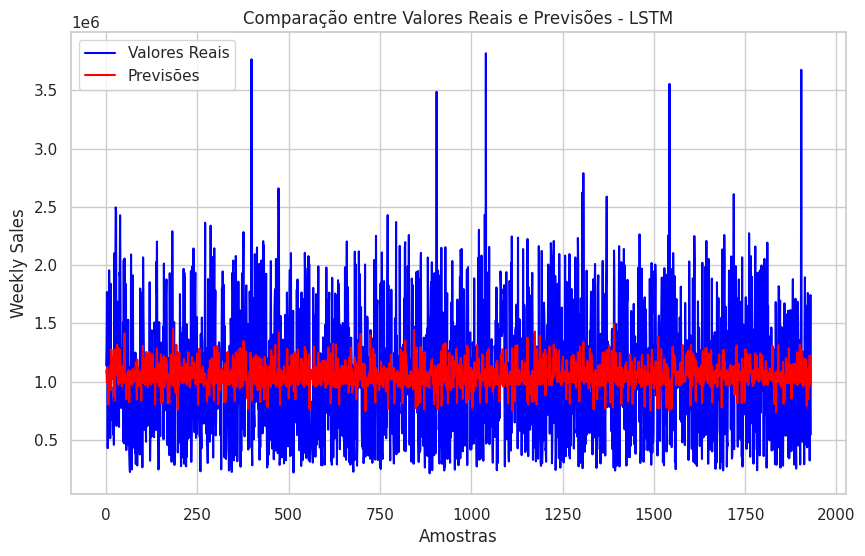

In [ ]:
y_test_LSTM_rescaled = scaler.inverse_transform(y_test_LSTM)
y_pred_LSTM_rescaled = scaler.inverse_transform(y_pred_LSTM)

plt.figure(figsize=(10, 6))
plt.plot(y_test_LSTM_rescaled, label='Valores Reais', color='blue')
plt.plot(y_pred_LSTM_rescaled, label='Previsões', color='red')
plt.title('Comparação entre Valores Reais e Previsões - LSTM')
plt.xlabel('Amostras')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

In [ ]:
# Cálculo do RMSE
rmse = np.sqrt(mean_squared_error(y_test_LSTM_rescaled, y_pred_LSTM_rescaled))
print(f'LSTM RMSE após inversão de escala: {rmse}')


LSTM RMSE após inversão de escala: 555016.4725787747


## Ajustando Hiperparâmentros

### Número de Neurônios nas Camadas LSTM

In [ ]:
# X_train = np.expand_dims(X_train_LSTM, axis=1)
# X_test = np.expand_dims(X_test_LSTM, axis=1)

# print(X_train.shape)
# print(X_test.shape)

# input_shape = (X_train.shape[1], X_train.shape[2])

# model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
# model.add(Dropout(0.2))
# model.add(LSTM(units=64))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
X_train = X_train_LSTM.reshape(X_train_LSTM.shape[0], X_train_LSTM.shape[1], X_train_LSTM.shape[2])
X_test = X_test_LSTM.reshape(X_test_LSTM.shape[0], X_test_LSTM.shape[1], X_test_LSTM.shape[2])


print(X_train.shape)
print(X_test.shape)

input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

(4504, 1, 5)
(1931, 1, 5)


In [ ]:
# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=2)


Epoch 1/50
71/71 - 3s - 42ms/step - loss: 0.0324 - val_loss: 0.0252
Epoch 2/50
71/71 - 0s - 5ms/step - loss: 0.0252 - val_loss: 0.0250
Epoch 3/50
71/71 - 0s - 5ms/step - loss: 0.0251 - val_loss: 0.0247
Epoch 4/50
71/71 - 0s - 5ms/step - loss: 0.0249 - val_loss: 0.0247
Epoch 5/50
71/71 - 0s - 5ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 6/50
71/71 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0246
Epoch 7/50
71/71 - 0s - 5ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 8/50
71/71 - 0s - 5ms/step - loss: 0.0248 - val_loss: 0.0247
Epoch 9/50
71/71 - 0s - 5ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 10/50
71/71 - 0s - 5ms/step - loss: 0.0246 - val_loss: 0.0246
Epoch 11/50
71/71 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 12/50
71/71 - 0s - 5ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 13/50
71/71 - 0s - 5ms/step - loss: 0.0246 - val_loss: 0.0246
Epoch 14/50
71/71 - 0s - 5ms/step - loss: 0.0246 - val_loss: 0.0245
Epoch 15/50
71/71 - 0s - 5ms/step - loss: 0.0245 - val_l

In [ ]:
# Fazer previsões
y_pred = model.predict(X_test)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Avaliar o desempenho do modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'LSTM Refinado RMSE: {rmse}')


LSTM Refinado RMSE: 0.15652795703074457


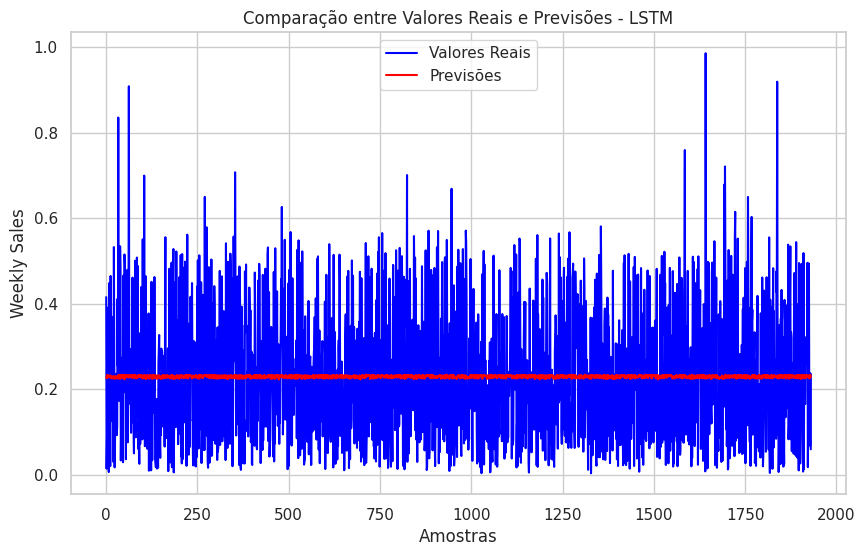

In [ ]:
# Visualizar a comparação entre valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reais', color='blue')
plt.plot(y_pred, label='Previsões', color='red')
plt.title('Comparação entre Valores Reais e Previsões - LSTM')
plt.xlabel('Amostras')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


### Ajustando mais hiperparâmetros

In [ ]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer=optimizer, loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=2)


Epoch 1/100
71/71 - 2s - 33ms/step - loss: 0.0643 - val_loss: 0.0497
Epoch 2/100
71/71 - 0s - 5ms/step - loss: 0.0404 - val_loss: 0.0304
Epoch 3/100
71/71 - 0s - 5ms/step - loss: 0.0281 - val_loss: 0.0258
Epoch 4/100
71/71 - 0s - 5ms/step - loss: 0.0262 - val_loss: 0.0256
Epoch 5/100
71/71 - 0s - 5ms/step - loss: 0.0264 - val_loss: 0.0255
Epoch 6/100
71/71 - 0s - 5ms/step - loss: 0.0263 - val_loss: 0.0254
Epoch 7/100
71/71 - 0s - 5ms/step - loss: 0.0260 - val_loss: 0.0253
Epoch 8/100
71/71 - 0s - 5ms/step - loss: 0.0261 - val_loss: 0.0252
Epoch 9/100
71/71 - 0s - 5ms/step - loss: 0.0256 - val_loss: 0.0252
Epoch 10/100
71/71 - 0s - 5ms/step - loss: 0.0255 - val_loss: 0.0251


**Validação estável:** A val_loss está estável em torno de 0.0252 a partir das primeiras 10 épocas, o que é um bom sinal de que o modelo não está sofrendo overfitting.

**Melhor perda:** A perda do modelo continua diminuindo de maneira estável a cada época.

---

### Reduzir o Número de Épocas com Early Stopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Testar Aumento de Dropout

In [ ]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.4))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1))

### Testando Outro Otimizador: RMSProp

In [ ]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=2)

Epoch 1/100
71/71 - 2s - 27ms/step - loss: 0.0636 - val_loss: 0.0508
Epoch 2/100
71/71 - 0s - 5ms/step - loss: 0.0431 - val_loss: 0.0341
Epoch 3/100
71/71 - 0s - 5ms/step - loss: 0.0304 - val_loss: 0.0263
Epoch 4/100
71/71 - 0s - 5ms/step - loss: 0.0261 - val_loss: 0.0252
Epoch 5/100
71/71 - 0s - 5ms/step - loss: 0.0256 - val_loss: 0.0251
Epoch 6/100
71/71 - 0s - 5ms/step - loss: 0.0256 - val_loss: 0.0250
Epoch 7/100
71/71 - 0s - 5ms/step - loss: 0.0256 - val_loss: 0.0250
Epoch 8/100
71/71 - 0s - 5ms/step - loss: 0.0255 - val_loss: 0.0249
Epoch 9/100
71/71 - 0s - 5ms/step - loss: 0.0254 - val_loss: 0.0249
Epoch 10/100
71/71 - 0s - 5ms/step - loss: 0.0253 - val_loss: 0.0249
Epoch 11/100
71/71 - 0s - 5ms/step - loss: 0.0253 - val_loss: 0.0249
Epoch 12/100
71/71 - 0s - 5ms/step - loss: 0.0253 - val_loss: 0.0248
Epoch 13/100
71/71 - 0s - 5ms/step - loss: 0.0254 - val_loss: 0.0248
Epoch 14/100
71/71 - 0s - 5ms/step - loss: 0.0252 - val_loss: 0.0248
Epoch 15/100
71/71 - 0s - 5ms/step - loss:

### Implementando L2 Regularization

In [ ]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(LSTM(units=64, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, kernel_regularizer=l2(0.01)))

### Revendo a Normalização dos Dados

In [ ]:
scaler = StandardScaler()
X_LSTM_scaled = scaler.fit_transform(X_LSTM)
y_LSTM_scaled = scaler.fit_transform(y_LSTM.values.reshape(-1, 1))


### Treinando o Modelo Novamente

In [ ]:
# Primeira Camada

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.3))

# Segunda Camada

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))

# Terceira Camada

model.add(LSTM(units=32))
model.add(Dropout(0.3))

# Camada densa final

model.add(Dense(1))

# Ajustando o otimizador com uma taxa de aprendizado (learning_rate=0.00005)

optimizer = keras.optimizers.RMSprop(learning_rate=0.00005)

# Compilando o modelo

model.compile(optimizer=optimizer, loss='mean_squared_error')



# Treinando o modelo

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=2)

Epoch 1/100
71/71 - 3s - 35ms/step - loss: 0.0747 - val_loss: 0.0700
Epoch 2/100
71/71 - 0s - 6ms/step - loss: 0.0685 - val_loss: 0.0640
Epoch 3/100
71/71 - 0s - 6ms/step - loss: 0.0626 - val_loss: 0.0582
Epoch 4/100
71/71 - 0s - 6ms/step - loss: 0.0566 - val_loss: 0.0524
Epoch 5/100
71/71 - 0s - 5ms/step - loss: 0.0508 - val_loss: 0.0468


In [ ]:
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Definindo o early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=2)

# Fazendo previsões
y_pred_LSTM = model.predict(X_test)

# Invertendo a escala para as previsões
y_pred_LSTM_inverted = scaler.inverse_transform(y_pred_LSTM)
y_test_LSTM_inverted = scaler.inverse_transform(y_test)

# Calculando o RMSE
rmse = np.sqrt(mean_squared_error(y_test_LSTM_inverted, y_pred_LSTM_inverted))
print(f'LSTM RMSE após inversão de escala: {rmse}')

Epoch 1/100
71/71 - 2s - 23ms/step - loss: 0.0684 - val_loss: 0.0639
Epoch 2/100
71/71 - 0s - 6ms/step - loss: 0.0624 - val_loss: 0.0581
Epoch 3/100
71/71 - 0s - 6ms/step - loss: 0.0566 - val_loss: 0.0524
Epoch 4/100
71/71 - 0s - 6ms/step - loss: 0.0507 - val_loss: 0.0468
Epoch 5/100
71/71 - 0s - 6ms/step - loss: 0.0453 - val_loss: 0.0414
Epoch 6/100
71/71 - 0s - 6ms/step - loss: 0.0400 - val_loss: 0.0365
Epoch 7/100
71/71 - 0s - 6ms/step - loss: 0.0354 - val_loss: 0.0323
Epoch 8/100
71/71 - 0s - 6ms/step - loss: 0.0314 - val_loss: 0.0289
Epoch 9/100
71/71 - 0s - 6ms/step - loss: 0.0283 - val_loss: 0.0266
Epoch 10/100
71/71 - 0s - 6ms/step - loss: 0.0267 - val_loss: 0.0253
Epoch 11/100
71/71 - 0s - 6ms/step - loss: 0.0257 - val_loss: 0.0248
Epoch 12/100
71/71 - 0s - 6ms/step - loss: 0.0253 - val_loss: 0.0246
Epoch 13/100
71/71 - 0s - 6ms/step - loss: 0.0256 - val_loss: 0.0246
Epoch 14/100
71/71 - 0s - 6ms/step - loss: 0.0254 - val_loss: 0.0246
Epoch 15/100
71/71 - 0s - 6ms/step - loss:

**Modelo refinado e treinado, com uma redução significativa no RMSE para 88,376 após inversão de escala.**

## **1. Avaliação e Ajustes Finais**

### Exploração de Outros Modelos:

### GRU (Gated Recurrent Units):
- GRUs são uma alternativa às LSTMs, oferecendo melhor desempenho em alguns casos, já que são mais leves e simples.
- Podemos testar uma arquitetura de GRU no lugar das LSTMs atuais e verificar a melhoria no RMSE.

### CNN-LSTM:
- Esse modelo combina a capacidade de extração de features das CNNs com a habilidade das LSTMs de capturar dependências temporais.
- Vamos tentar integrar camadas convolucionais antes das camadas LSTM para verificar se há melhorias no desempenho.

## Ajuste de Hiperparâmetros:
- Podemos explorar **Grid Search** ou **Random Search** para otimizar os hiperparâmetros (como `batch_size`, `epochs`, e `learning_rate`).
- Outra abordagem seria usar uma biblioteca como **Optuna** para busca de hiperparâmetros automatizada, melhorando a eficiência da busca.

## **2. Visualização e Interpretação**

## Gráficos de Residuals:
- Podemos plotar gráficos comparando os erros das previsões com os valores reais ao longo do tempo. Isso ajudará a identificar padrões de erro que o modelo possa estar ignorando.

## Análise de Erro por Janela Temporal:
- Dividiremos os dados de previsão em diferentes períodos (semanas, meses, trimestres) e calcularemos o **RMSE** para cada período.
- Isso nos ajudará a entender como o modelo se comporta em diferentes fases (ex: sazonalidades, tendências específicas) e pode revelar áreas de melhoria.

## **3. Deploy e Integração**

## Preparar o Modelo para Deploy:
- Podemos criar um **Dockerfile** que empacote o modelo com as bibliotecas necessárias (TensorFlow, Scikit-learn, etc.).
- O modelo pode ser servido em uma API usando **FastAPI** ou **Flask**, permitindo previsões em tempo real com uma interface simples para integração com outros sistemas.

## Monitoramento de Desempenho:
- Após o deploy, monitoraremos o desempenho do modelo ao longo do tempo, registrando os erros e atualizando o modelo conforme necessário.
- Podemos usar ferramentas como **Prometheus** ou **Grafana** para o monitoramento contínuo do desempenho do modelo em produção.

---

Você gostaria de começar testando outros modelos (GRU ou CNN-LSTM), ou preferiria iniciar pela busca de hiperparâmetros com **Grid Search** ou **Random Search**? Também podemos gerar os gráficos de residuals ou preparar o ambiente de deploy em Docker, com uma API para previsões em tempo real.





#### **Implementando o modelo GRU**

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam

# Definir o modelo GRU
model_gru = Sequential()
model_gru.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dropout(0.3))
model_gru.add(GRU(units=64, return_sequences=True))
model_gru.add(Dropout(0.3))
model_gru.add(GRU(units=32))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(1))  # Saída

# Compilar o modelo
optimizer = Adam(learning_rate=0.00005)
model_gru.compile(optimizer=optimizer, loss='mean_squared_error')

# Treinar o modelo
history_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=64,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping], verbose=2)

# Fazer previsões
y_pred_gru = model_gru.predict(X_test)

# Inverter a escala para as previsões
y_pred_gru_inverted = scaler.inverse_transform(y_pred_gru)
y_test_gru_inverted = scaler.inverse_transform(y_test)

# Calcu


Epoch 1/100
71/71 - 3s - 40ms/step - loss: 0.0618 - val_loss: 0.0454
Epoch 2/100
71/71 - 0s - 6ms/step - loss: 0.0382 - val_loss: 0.0295
Epoch 3/100
71/71 - 0s - 6ms/step - loss: 0.0292 - val_loss: 0.0257
Epoch 4/100
71/71 - 0s - 6ms/step - loss: 0.0272 - val_loss: 0.0253
Epoch 5/100
71/71 - 0s - 6ms/step - loss: 0.0273 - val_loss: 0.0252
Epoch 6/100
71/71 - 0s - 6ms/step - loss: 0.0270 - val_loss: 0.0252
Epoch 7/100
71/71 - 0s - 6ms/step - loss: 0.0273 - val_loss: 0.0251
Epoch 8/100
71/71 - 0s - 6ms/step - loss: 0.0268 - val_loss: 0.0251
Epoch 9/100
71/71 - 0s - 6ms/step - loss: 0.0267 - val_loss: 0.0250
Epoch 10/100
71/71 - 0s - 6ms/step - loss: 0.0267 - val_loss: 0.0250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


#### **Implementando o modelo CNN-LSTM**

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, LSTM

# Definindo o modelo CNN-LSTM
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=1, activation='relu',
                         input_shape=(X_train.shape[1], X_train.shape[2])))

model_cnn_lstm.add(MaxPooling1D(pool_size=1))
model_cnn_lstm.add(LSTM(units=64, return_sequences=True))
model_cnn_lstm.add(Dropout(0.3))
model_cnn_lstm.add(LSTM(units=32))
model_cnn_lstm.add(Dropout(0.3))
model_cnn_lstm.add(Dense(1))

# Compilando o modelo
optimizer = Adam(learning_rate=0.00005)
model_cnn_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Treinar o modelo
history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, epochs=100, batch_size=64,
                                      validation_data=(X_test, y_test),
                                      callbacks=[early_stopping], verbose=2)

# Fazer previsões
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)

# Inverter a escala para as previsões
y_pred_cnn_lstm_inverted = scaler.inverse_transform(y_pred_cnn_lstm)
y_test_cnn_lstm_inverted = scaler.inverse_transform(y_test)

# Calcular o RMSE
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test_cnn_lstm_inverted, y_pred_cnn_lstm_inverted))
print(f'CNN-LSTM RMSE após inversão de escala: {rmse_cnn_lstm}')

Epoch 1/100
71/71 - 4s - 53ms/step - loss: 0.0720 - val_loss: 0.0645
Epoch 2/100
71/71 - 0s - 6ms/step - loss: 0.0603 - val_loss: 0.0527
Epoch 3/100
71/71 - 0s - 6ms/step - loss: 0.0479 - val_loss: 0.0405
Epoch 4/100
71/71 - 0s - 6ms/step - loss: 0.0367 - val_loss: 0.0308
Epoch 5/100
71/71 - 0s - 6ms/step - loss: 0.0296 - val_loss: 0.0267
Epoch 6/100
71/71 - 0s - 6ms/step - loss: 0.0277 - val_loss: 0.0259
Epoch 7/100
71/71 - 0s - 6ms/step - loss: 0.0275 - val_loss: 0.0258
Epoch 8/100
71/71 - 0s - 6ms/step - loss: 0.0272 - val_loss: 0.0257
Epoch 9/100
71/71 - 0s - 6ms/step - loss: 0.0272 - val_loss: 0.0256
Epoch 10/100
71/71 - 0s - 6ms/step - loss: 0.0269 - val_loss: 0.0256
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
CNN-LSTM RMSE após inversão de escala: 143328.82518763962


#### **Gerando Gráficos de Resíduos**

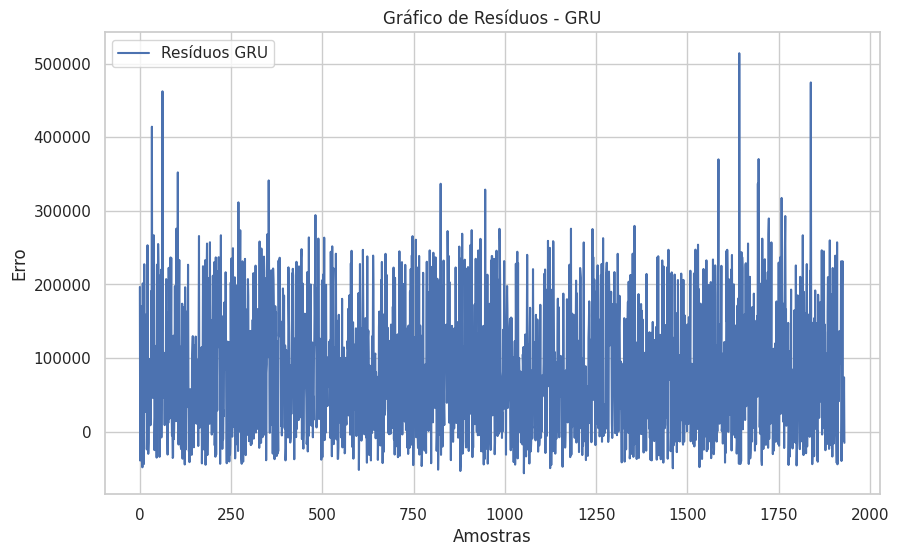

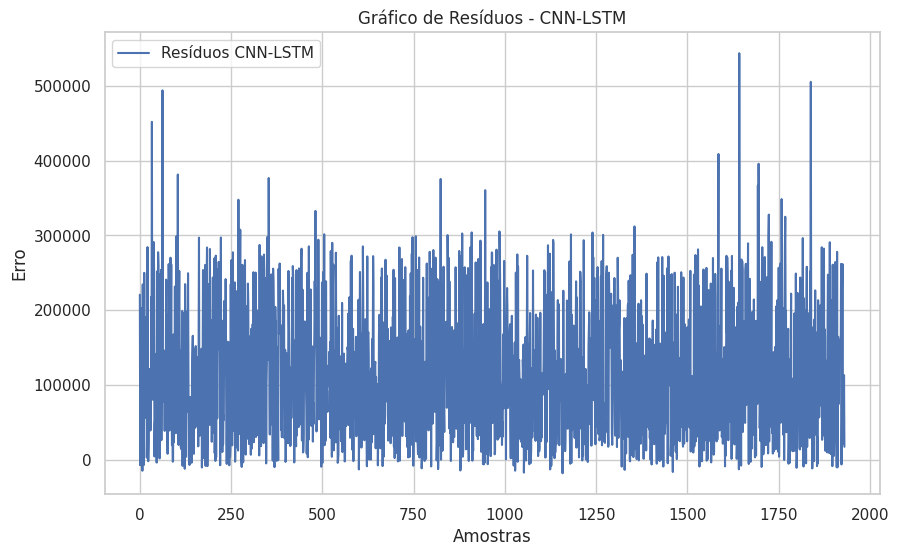

In [ ]:
# Resíduos do GRU
residuals_gru = y_test_gru_inverted - y_pred_gru_inverted

plt.figure(figsize=(10, 6))
plt.plot(residuals_gru, label='Resíduos GRU')
plt.title('Gráfico de Resíduos - GRU')
plt.xlabel('Amostras')
plt.ylabel('Erro')
plt.legend()
plt.show()

# Resíduos do CNN-LSTM
residuals_cnn_lstm = y_test_cnn_lstm_inverted - y_pred_cnn_lstm_inverted

plt.figure(figsize=(10, 6))
plt.plot(residuals_cnn_lstm, label='Resíduos CNN-LSTM')
plt.title('Gráfico de Resíduos - CNN-LSTM')
plt.xlabel('Amostras')
plt.ylabel('Erro')
plt.legend()
plt.show()


#### **Gráfico de Séries Temporais para o Melhor Modelo**

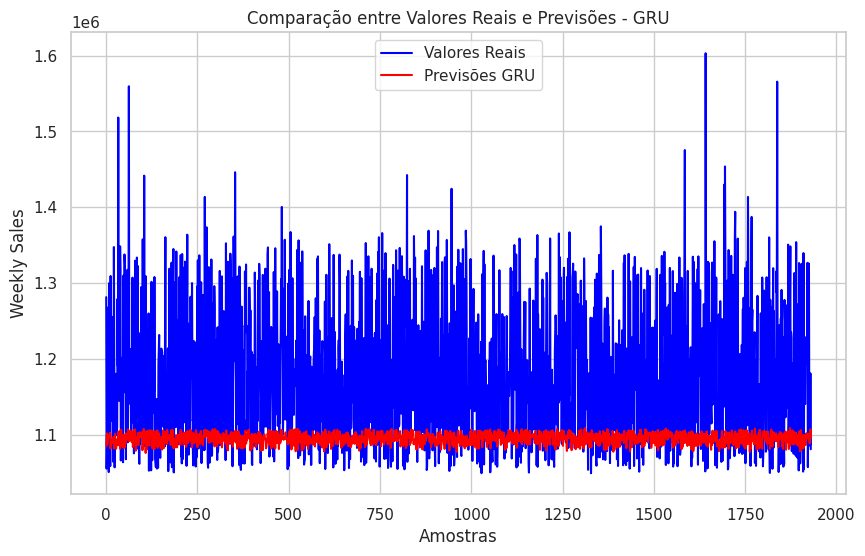

In [ ]:
# Gráfico comparando o melhor modelo (exemplo usando GRU)
plt.figure(figsize=(10, 6))
plt.plot(y_test_gru_inverted, label='Valores Reais', color='blue')
plt.plot(y_pred_gru_inverted, label='Previsões GRU', color='red')
plt.title('Comparação entre Valores Reais e Previsões - GRU')
plt.xlabel('Amostras')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


# Exportando modelo

In [ ]:
# Definindo o modelo LSTM (exemplo)
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(1))  # Camada de saída
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Avaliação do desempenho do modelo
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'LSTM RMSE: {rmse}')


Epoch 1/50
71/71 - 3s - 40ms/step - loss: 0.0336 - val_loss: 0.0250
Epoch 2/50
71/71 - 0s - 6ms/step - loss: 0.0253 - val_loss: 0.0249
Epoch 3/50
71/71 - 0s - 6ms/step - loss: 0.0251 - val_loss: 0.0247
Epoch 4/50
71/71 - 0s - 5ms/step - loss: 0.0249 - val_loss: 0.0247
Epoch 5/50
71/71 - 0s - 5ms/step - loss: 0.0249 - val_loss: 0.0246
Epoch 6/50
71/71 - 0s - 5ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 7/50
71/71 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0247
Epoch 8/50
71/71 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0246
Epoch 9/50
71/71 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0246
Epoch 10/50
71/71 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 11/50
71/71 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 12/50
71/71 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0246
Epoch 13/50
71/71 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0246
Epoch 14/50
71/71 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0246
Epoch 15/50
71/71 - 0s - 5ms/step - loss: 0.0246 - val_l

In [ ]:
# Salvando o modelo em um arquivo .h5
model.save('lstm_model.h5')
